# First method: explicit in time, forward / backword differences in space
## Setting up the problem by defining a function for the derivative

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

n_x = 1000

R1o = 0.01
R2o = 1
Lo = 3.0
Co = 3.0
RL = 1000.0

dx = 0.001

R1 = R1o * dx
R2 = R2o / dx
L = Lo * dx
C = Co * dx

x_array = np.arange(n_x) * dx


def get_derivative(t, x):
    v = x[:n_x]
    i = x[n_x:]

    u = np.sin(t*10)

    # if t <= (1+1/3.0)  and t >= 1:
    #     #u = 1
    #     # u = np.sin(np.pi*(t-1))
    #     u = 3*( (t-1)*3 )**2 - 2*( (t-1)*3 )**3
    # elif t>(1+1/3.0)and t<(2-1/3.0):
    #     u = 1
    # elif t>=(2-1/3.0) and t<= 2:
    #     u = 1 - (3*( (t-(2-1/3.0))*3 )**2 - 2*( (t-(2-1/3.0))*3 )**3)
    # else:
    #     u = 0

    # if t >= 3 and t<= 3.1:
    #     C = 0.001
    # else:
    #     C = Co * dx

    v[0] = u
    i[-1] = v[-1]/RL
    
    der_v = np.zeros(v.shape)
    der_i = np.zeros(i.shape)
    
    # Central differences instead of forward / backward differences
    # der_v[1:-1] = 1/C* ((i[:-2] - i[2:])/2 - v[1:-1] / R2)
    # der_i[1:-1] = 1/L* ((v[:-2] - v[2:])/2 - i[1:-1] * R1)
    # der_v[-1] = 1/C* (-i[-1] + i[-2] - v[-1] / R2)
    # der_i[0] = 1/L* (-v[1] + v[0] - i[0] * R1)

    
    der_v[1:] = 1/C* (i[:-1] - i[1:] - v[1:] / R2) # 1/R2 = G

    # introduce fault
    # if t > 30 and t<31:
    #     der_v[int(n_x/2)] = 1/C* (i[int(n_x/2)-1] - i[int(n_x/2)] - v[int(n_x/2)] / R2*10000)
    
    der_i[:-1] = 1/L* (-v[1:] + v[:-1] - i[:-1] * R1)
    
    return np.concatenate((der_v, der_i))
    

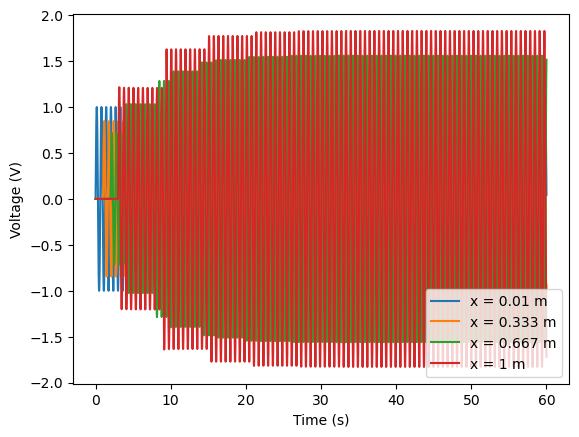

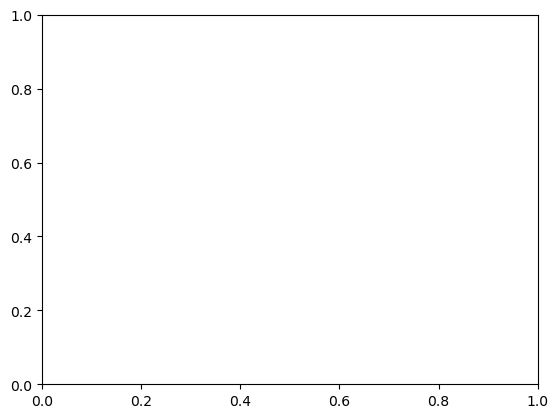

In [2]:
sol = solve_ivp(get_derivative, [0, 60], np.zeros(2*n_x), method='RK45', dense_output=True, rtol=1e-9, atol=1e-9)
plt.plot(sol.t, sol.y[0,:], label="x = 0.01 m")
plt.plot(sol.t, sol.y[int(n_x/3),:], label="x = 0.333 m")
plt.plot(sol.t, sol.y[int(2*n_x/3),:], label="x = 0.667 m")
plt.plot(sol.t, sol.y[n_x-1,:], label= "x = 1 m")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend(loc="lower right")
plt.show()

# fig = plt.figure()
# ax = fig.subplots()
# T, X = np.meshgrid(sol.t, x_array)
# ax.pcolormesh(T, X, sol.y[:n_x, :])

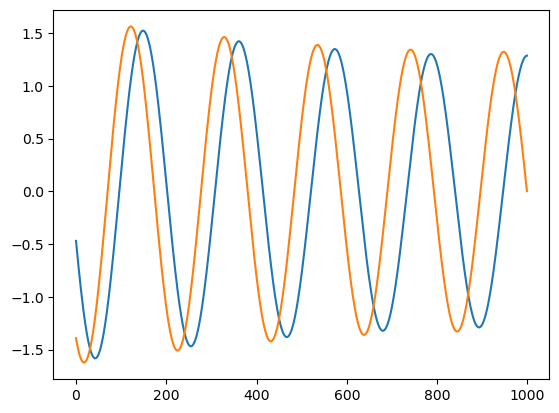

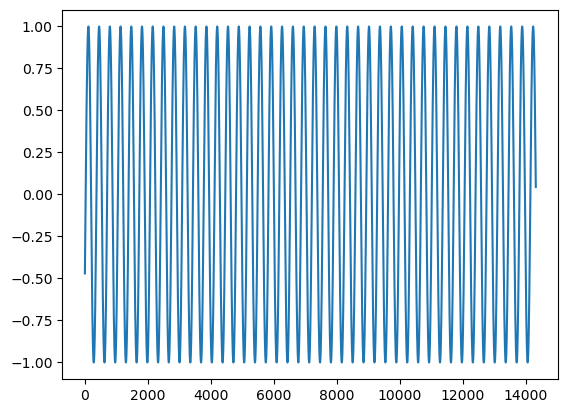

In [11]:

n_t = sol.y.shape[1]
u_bc = sol.y[0,int(n_t/6*4):]
u_0 = sol.y[:n_x,int(n_t/6*4)]
i_0 = sol.y[n_x:,int(n_t/6*4)]

plt.plot(u_0)
plt.plot(i_0)
plt.show()

plt.figure()
plt.plot(u_bc)

# Godunov's method to solve the PDEs 
## which is explicit in time as well 

nx:  100
nt:  100000


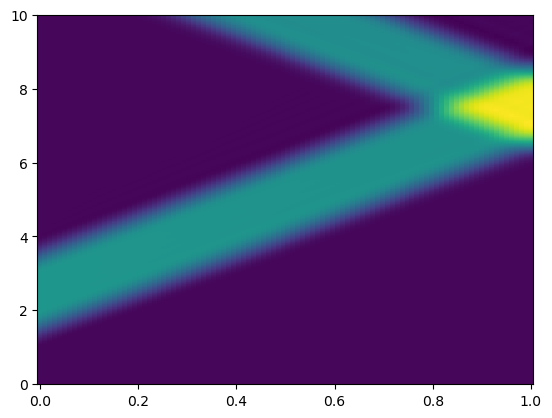

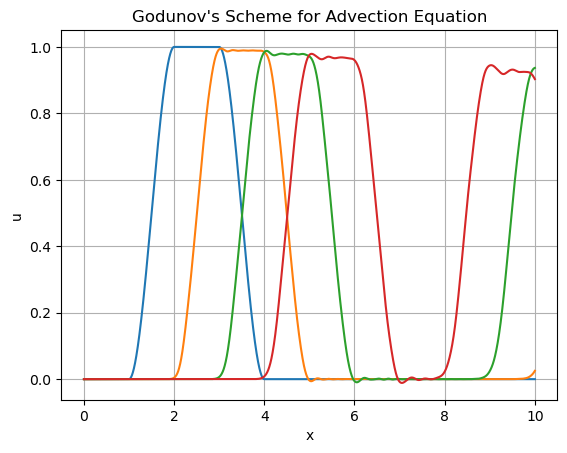

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
dx = 0.1  # Cell size
x_f = 10.0
nx = int(x_f/dx)
print('nx: ',nx)
dt = 0.0001  # Time step
t_f = 10
nt = int(np.round_(t_f / dt))
print('nt: ',nt)

R = 0.01
L = 0.5
G = 1/10**3
C = 0.5
RL = 1000


# Initialize solution
u = np.zeros((nx, nt))
i = np.zeros((nx, nt))

# u[0,int(0.1*t_f/dt):int(0.4*t_f/dt)] = 1.0  # Initial condition (step function)

# u[0,int(0.1*t_f/dt):int(0.4*t_f/dt)] = np.sin(np.arange(0,int(0.3*t_f/dt))*np.pi/int(0.3*t_f/dt))  # Initial condition (sine function)

u[0,int(0.1*t_f/dt):int(0.2*t_f/dt)] = 3*( np.arange(0,int(0.1*t_f/dt) ) / int(0.1*t_f/dt) )**2 - 2*( np.arange(0,int(0.1*t_f/dt) ) / int(0.1*t_f/dt) )**3
u[0,int(0.2*t_f/dt):int(0.3*t_f/dt)] = 1
u[0,int(0.3*t_f/dt):int(0.4*t_f/dt)] = 1-(3*( np.arange(0,int(0.1*t_f/dt)) / int(0.1*t_f/dt) )**2 - 2*( np.arange(0,int(0.1*t_f/dt) ) / int(0.1*t_f/dt))**3)

# u[0,:] = np.sin(np.arange(0,)*np.pi/int(0.3*t_f/dt))

# Time-stepping loop
for n in range(1,nt):
    # Compute fluxes at cell interfaces

    i[:-1,n] = i[:-1,n-1] - dt * (1/L *(u[1:,n-1] - u[:-1,n-1])/ dx   + R / L * i[:-1,n-1] )

    i[-1,n] = u[-1,n]/RL

    u[1:,n] = u[1:,n-1] - dt * (1/L *(i[1:,n-1] - i[:-1,n-1])/ dx   + G / C * u[:-1,n-1] )
 

fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(np.linspace(0,10,int(nt/100)), np.linspace(0,1,nx))

ax.pcolormesh(X, T, u[:,0::100])

# Plot the final solution
plt.figure()
x = np.linspace(0, nt * dt, nt)
plt.plot(x, u[00,:])
plt.plot(x, u[20,:])
plt.plot(x, u[40,:])
plt.plot(x, u[60,:])
plt.xlabel("x")
plt.ylabel("u")
plt.title("Godunov's Scheme for Advection Equation")
plt.grid(True)
plt.show()

# Forward / Backward in space, but *implicit* in time

nx:  100
nt:  10000


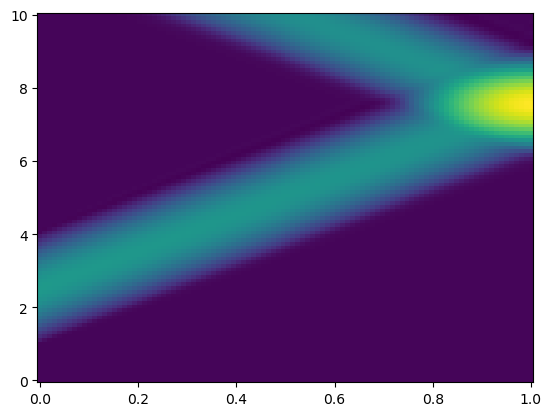

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Parameters
dx = 0.1  # Cell size
x_f = 10.0
nx = int(x_f/dx)
print('nx: ',nx)
dt = 0.001  # Time step
t_f = 10
nt = int(np.round_(t_f / dt))
print('nt: ',nt)


R = 0.01
L = 0.5
G = 1/10**3
C = 0.5
RL = 1000

# Initialize solution
u = np.zeros((nx, nt))
i = np.zeros((nx, nt))
# u[0,int(0.1*t_f/dt):int(0.4*t_f/dt)] = 1.0  # Initial condition (step function)
u[0,int(0.1*t_f/dt):int(0.4*t_f/dt)] = np.sin(np.arange(0,int(0.3*t_f/dt))*np.pi/int(0.3*t_f/dt))  # Initial condition (sine function)

A_11 = np.eye(nx-1)*(1 + R *dt / L) 
A_12 = -np.eye(nx-1,k=-1)*(dt/(L * dx)) + np.eye(nx-1)*(dt/(L *dx))
A_21 = -np.eye(nx-1)*(dt/(C * dx)) + np.eye(nx-1,k=1)*(dt/(C *dx))
A_22 = np.eye(nx-1)*(1 + G *dt / C)

A = np.block([[A_11, A_12],[A_21, A_22]])

# Time-stepping loop
for n in range(nt-1):

    z_n = np.hstack((i[:-1,n], u[1:,n]))

    z_n[0] = z_n[0] + dt/L/dx * u[0,n]
    z_n[-1] = z_n[-1] - dt/L/dx * i[-1,n]

    z_np1 = scipy.linalg.solve(A, z_n)

    i[:-1,n+1] = z_np1[:nx-1]
    u[1:,n+1] = z_np1[nx-1:]
    i[-1,n] = u[-1,n]/RL                                                           

fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(np.linspace(0,10,int(nt/100)), np.linspace(0,1,nx))

ax.pcolormesh(X, T, u[:,0::100])


# Trying the second order upwind scheme
## still explicit. using forwward / backward method on the boundaries

nx:  100
nt:  100000


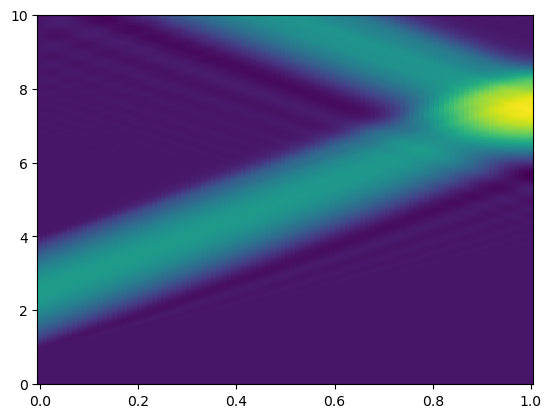

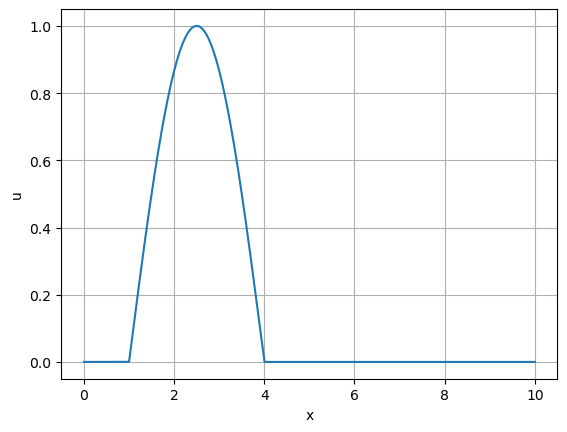

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
dx = 0.1  # Cell size
x_f = 10.0
nx = int(x_f/dx)
print('nx: ',nx)
dt = 0.0001  # Time step
t_f = 10
nt = int(np.round_(t_f / dt))
print('nt: ',nt)


R = 0.01
L = 0.5
G = 1/10**3
C = 0.5
RL = 1000

R_tilde = np.array([[R, 0],[0, G]])
L_tilde = np.array([[0, L],[C, 0]])

# Initialize solution
u = np.zeros((nx, nt))
i = np.zeros((nx, nt))
# u[0,int(0.1*t_f/dt):int(0.4*t_f/dt)] = 1.0  # Initial condition (step function)
u[0,int(0.1*t_f/dt):int(0.4*t_f/dt)] = np.sin(np.arange(0,int(0.3*t_f/dt))*np.pi/int(0.3*t_f/dt))  # Initial condition (sine function)


# Time-stepping loop
for n in range(1,nt):
    # Compute fluxes at cell interfaces


    # i[1:-1,n] = i[1:-1,n-1] + dt * (1/L * (u[2:,n-1] - u[:-2,n-1])/ 2/dx   +  R / L * i[1:-1,n-1] )
    # i[0,n] = i[0,n-1] + dt * (1/L * (u[1,n-1] - u[0,n-1])/ dx   +  R / L * i[0,n-1] )
    
    # u[1:-1,n] = u[1:-1,n-1] + dt * (1/C * ( i[2:,n-1] - i[:-2,n-1])/ 2/dx   +  G / C * u[:-2,n-1] )
    # u[-1,n] = u[-1,n-1] + dt * (1/C * (i[-1,    n-1] - i[-2,n-1])/ dx   +  G / C * u[0,n-1] )
    # i[-1,n] = u[-1,n]/RL

    ########## second order forward
    i[:-2,n] = i[:-2,n-1] - dt * (1/L * (-1*u[2:,n-1] + 4*u[1:-1,n-1] - 3* u[:-2,n-1])/ 2/dx   + R / L * i[:-2,n-1] )
    i[-2,n] = i[-2,n-1] - dt * (1/L * (u[-1,n-1] - u[-2,n-1])/ dx   + R / L * i[-1,n-1] )
    i[-1,n] = u[-1,n]/RL
    u[1,n] = u[1,n-1] - dt * (1/C * (i[1,n-1] - i[0,n-1])/ dx   + G / C * u[0,n-1] )
    u[2:,n] = u[2:,n-1] - dt * (1/C * (3*i[2:,n-1] - 4*i[1:-1,n-1] + i[:-2,n-1])/ 2/dx   + G / C * u[:-2,n-1] )

    ########## USING CLIPPING
    # i[:-2,n] = i[:-2,n-1] - np.clip(-1,dt * (1/L * (-1*u[2:,n-1] + 4*u[1:-1,n-1] - 3* u[:-2,n-1])/ 2/dx   + R / L * i[:-2,n-1] ),1)
    # i[-2,n] = i[-2,n-1] - np.clip(-1,dt * (1/L * (u[-1,n-1] - u[-2,n-1])/ dx   + R / L * i[-1,n-1] ),1)
    # i[-1,n] = u[-1,n]/RL
    # u[1,n] = u[1,n-1] - np.clip(-1,dt * (1/C * (i[1,n-1] - i[0,n-1])/ dx   + G / C * u[0,n-1] ),1)
    # u[2:,n] = u[2:,n-1] - np.clip(-1,dt * (1/C * (3*i[2:,n-1] - 4*i[1:-1,n-1] + i[:-2,n-1])/ 2/dx   + G / C * u[:-2,n-1] ),1)
    
fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(np.linspace(0,10,int(nt/100)), np.linspace(0,1,nx))

ax.pcolormesh(X, T, u[:,0::100])

plt.figure()
# Plot the final solution
x = np.linspace(0, nt * dt, nt)
plt.plot(x,u[0,:])
# t = np.linspace(0, nx * dx, nx)
# plt.plot(t, u[:,50000])

plt.xlabel("x")

plt.ylabel("u")
plt.grid(True)
plt.show()



# Fully IMPLICIT method (basically the same approach as used in the first paper)

100
100


/opt/miniconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


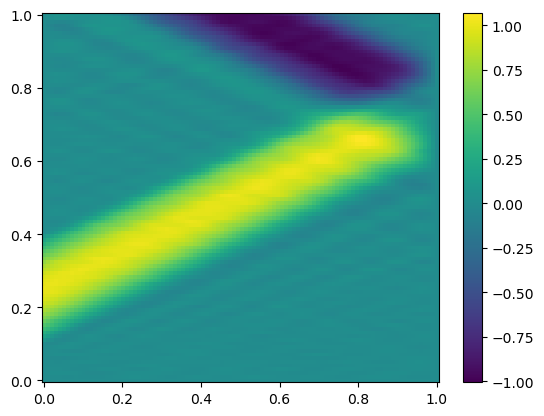

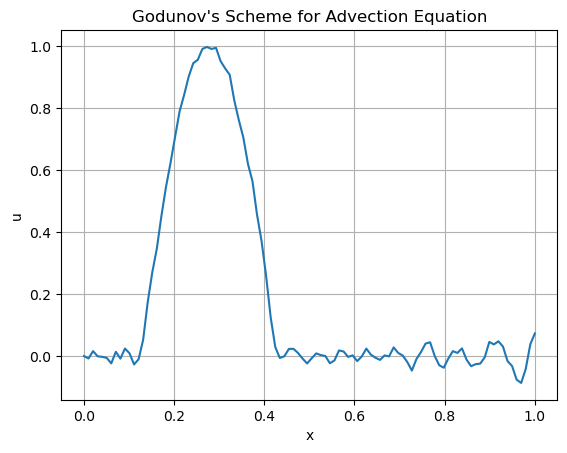

In [8]:
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

# Parameters
dx = 0.01  # Cell size
x_f = 1
nx = int(x_f/dx)
print(nx)
dt = 0.01  # Time step
t_f = 1
nt = int(np.round_(t_f / dt))
print(nt)


R = 0.01
L = 0.5
G = 1/10**3
C = 0.5
RL = 1000

alpha = L * dx/dt
beta = 2 * R * dx

alpha_prime = C * dx/dt
beta_prime = 2 * G * dx

A_max = scipy.sparse.csc_matrix((2*nx*nt,2*nx*nt))

for i in range(nx*nt):
    if i < nt:
        if i%nt == 0: # Initial Condition
            A_max[i,i] = 1
        else:
            A_max[i,i] = beta
            A_max[i,i+1] = alpha
            A_max[i,i-1] = -alpha

            A_max[i,i+nx*nt] = - 2
            A_max[i,i+nx*nt+nt] =  2

    elif i > (nx-1)*nt: # Boundary Condition for I = U * RL
        A_max[i,i] = 1
        A_max[i,i+nx*nt] = RL
    else:

        if i%nt == 0: # Initial Condition
            A_max[i,i] = 1

        elif i%nt == nt-1:
            A_max[i,i] = beta + 2*alpha
            A_max[i,i-1] = -2*alpha 

            A_max[i,i+nx*nt - nt] = - 1
            A_max[i,i+nx*nt +nt] =  1
        else:
            A_max[i,i] = beta
            A_max[i,i+1] = alpha
            A_max[i,i-1] = -alpha

            A_max[i,i+nx*nt - nt] = - 1
            A_max[i,i+nx*nt +nt] =  1

for i in range(nx*nt,2*nx*nt):
    if i < (nx+1)*nt:
        A_max[i,i] = 1

    elif i > 2*nx*nt - nt:

        if i%nt == nt-1:
            A_max[i,i] = beta_prime + 2*alpha_prime
            A_max[i,i-1] = - 2*alpha_prime

            A_max[i,i-nx*nt - nt] = - 2
            A_max[i,i-nx*nt] =  2
        else:
            A_max[i,i] = beta_prime
            A_max[i,i+1] = alpha_prime
            A_max[i,i-1] = -alpha_prime

            A_max[i,i-nx*nt - nt] = - 2
            A_max[i,i-nx*nt] =  2

    else:
        if i%nt == 0: # Initial Condition
            A_max[i,i] = 1

        elif i%nt == nt-1:
            A_max[i,i] = beta_prime + 2*alpha_prime
            A_max[i,i-1] = - 2*alpha_prime

            A_max[i,i-nx*nt - nt] = - 1
            A_max[i,i-nx*nt +nt] =  1

        else:
            A_max[i,i] = beta_prime
            A_max[i,i+1] = alpha_prime
            A_max[i,i-1] = -alpha_prime

            A_max[i,i-nx*nt - nt] = - 1
            A_max[i,i-nx*nt +nt] =  1

b_0 = np.zeros(nx*nt*2)

temp = np.zeros(nx)
temp[int(0.1*t_f/dt):int(0.4*t_f/dt)] = np.sin(np.arange(0,int(0.3*t_f/dt))*np.pi/int(0.3*t_f/dt))

b_0[nx*nt:(nx+1)*nt] = temp

res = scipy.sparse.linalg.spsolve(A_max,b_0)

u = np.reshape(res[nx*nt:],(nx,nt))

fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(np.linspace(0,1,int(nt)), np.linspace(0,1,nx))

here = ax.pcolormesh(X, T, u[:,:])
fig.colorbar(here)


# Plot the final solution

plt.figure()
x = np.linspace(0, nt * dt, nt)
plt.plot(x,u[5,:])
# t = np.linspace(0, nx * dx, nx)
# plt.plot(t, u[:,50000])

plt.xlabel("x")

plt.ylabel("u")
plt.grid(True)
plt.show()


# the end lol